In [ ]:
# Cell 1: Setup & imports
!pip install --quiet scikit-learn matplotlib tqdm tensorflow==2.14.1

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# sklearn / tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks
tf.get_logger().setLevel('ERROR')

print("TF version:", tf.__version__)


ERROR: Could not find a version that satisfies the requirement tensorflow==2.14.1 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.14.1
TF version: 2.19.0


In [ ]:
# Cell 2: Config & helpers
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Simulation params (tweak these)
N_PATIENTS = 800         # reduce if Colab is slow
PREVALENCE = 0.035
MAX_MONTHS = 60
WINDOW_SIZE_MONTHS = 6
VISIT_RATE_PER_YEAR = 1.5

# Small helper
def month_windows(max_months=MAX_MONTHS, window_size=WINDOW_SIZE_MONTHS):
    return np.arange(1, max_months+1, window_size)


In [ ]:
# Cell 3: Synthetic cohort generator (creates labs + occasional imaging proxies)
ages = np.random.randint(45, 86, size=N_PATIENTS)
sex = np.random.binomial(1, 0.48, size=N_PATIENTS)
smoker = np.random.binomial(1, 0.2, size=N_PATIENTS)
family_history = np.random.binomial(1, 0.05, size=N_PATIENTS)
is_case = np.random.binomial(1, PREVALENCE, size=N_PATIENTS)
diagnosis_month = np.where(is_case==1, np.random.randint(24, MAX_MONTHS+1, size=N_PATIENTS), np.nan)

lab_records = []
imaging_records = []

def simulate_patient(pid, age, male, smoker_flag, fam_hist, is_case_flag, dx_month):
    glucose_base = np.random.normal(95 + (age-60)*0.1, 8)
    weight_base = np.random.normal(75 - (age-50)*0.1, 10)
    ca19_9_base = max(1.0, np.random.normal(12, 8))
    if is_case_flag:
        glucose_start = int(max(1, dx_month - np.random.randint(6, 36)))
        glucose_drift = np.random.normal(0.015, 0.01)
        weight_start = int(max(1, dx_month - np.random.randint(6, 36)))
        weight_delta = np.random.normal(-0.25, 0.15)
        ca_start = int(max(1, dx_month - np.random.randint(6, 30)))
        ca_drift = np.random.normal(0.05, 0.03)
        duct_start = int(max(1, dx_month - np.random.randint(6, 18)))
        duct_slope = np.random.normal(0.01, 0.005)
        texture_start = int(max(1, dx_month - np.random.randint(6, 24)))
        texture_slope = np.random.normal(0.01, 0.008)
    else:
        glucose_start=None; glucose_drift=0.0
        weight_start=None; weight_delta=0.0
        ca_start=None; ca_drift=0.0
        duct_start=None; duct_slope=0.0
        texture_start=None; texture_slope=0.0

    months = np.arange(1, MAX_MONTHS+1)
    p_visit = VISIT_RATE_PER_YEAR / 12.0
    has_visit = np.random.binomial(1, p_visit, size=MAX_MONTHS)
    visit_months = months[has_visit==1]
    if len(visit_months)==0:
        visit_months = np.array([np.random.randint(1, MAX_MONTHS+1)])

    for m in visit_months:
        # glucose
        if is_case_flag and glucose_start is not None and m >= glucose_start:
            months_since = m - glucose_start + 1
            g = glucose_base * ((1 + glucose_drift) ** months_since) + np.random.normal(0,4)
        else:
            g = glucose_base + np.random.normal(0,6)
        lab_records.append((pid,m,"glucose",g))

        # weight
        if is_case_flag and weight_start is not None and m >= weight_start:
            months_since = m - weight_start + 1
            w = weight_base + weight_delta * months_since + np.random.normal(0,1.5)
        else:
            w = weight_base + np.random.normal(0,2.0)
        lab_records.append((pid,m,"weight",w))

        # ALT
        if is_case_flag and m >= max(1, dx_month - 12):
            alt = np.random.normal(45,10)
        else:
            alt = np.random.normal(30,8)
        lab_records.append((pid,m,"ALT",alt))

        # CA19-9
        if is_case_flag and ca_start is not None and m >= ca_start:
            months_since = m - ca_start + 1
            ca = ca19_9_base * ((1 + ca_drift) ** months_since) + np.random.normal(0,5)
        else:
            ca = ca19_9_base + np.random.normal(0,3)
        lab_records.append((pid,m,"CA19_9",ca))

        # CRP
        crp = max(0.01, np.random.normal(2.0, 1.0))
        lab_records.append((pid,m,"CRP",crp))

        # imaging proxies occasionally
        if np.random.rand() < 0.25:
            if is_case_flag and duct_start is not None and m >= duct_start:
                duct = max(0.0, 0.1 + duct_slope * (m - duct_start + 1) + np.random.normal(0,0.02))
            else:
                duct = np.clip(np.random.normal(0.02,0.02),0.0,1.0)
            if is_case_flag and texture_start is not None and m >= texture_start:
                texture = np.clip(0.1 + texture_slope * (m - texture_start + 1) + np.random.normal(0,0.03),0.0,1.0)
            else:
                texture = np.clip(np.random.normal(0.02,0.02),0.0,1.0)
            atrophy = np.clip(np.random.normal(0.02,0.02),0.0,1.0)
            asym = np.clip(np.random.normal(0.01,0.01),0.0,1.0)
            imaging_records.append((pid,m,duct,atrophy,texture,asym))

# run simulation
for pid in tqdm(range(N_PATIENTS)):
    simulate_patient(pid, ages[pid], sex[pid], smoker[pid], family_history[pid], is_case[pid], diagnosis_month[pid])

labs_df = pd.DataFrame(lab_records, columns=["patient_id","month","obs","value"])
imaging_df = pd.DataFrame(imaging_records, columns=["patient_id","month","duct_score","atrophy_index","texture_score","asymmetry_index"])
manifest = pd.DataFrame({
    "patient_id": np.arange(N_PATIENTS),
    "age": ages,
    "sex_male": sex,
    "smoker": smoker,
    "family_history": family_history,
    "is_case": is_case,
    "diagnosis_month": diagnosis_month
})

print("patients:", manifest.shape[0], "lab rows:", labs_df.shape[0], "imaging rows:", imaging_df.shape[0])


100%|██████████| 800/800 [00:00<00:00, 8582.29it/s]

patients: 800 lab rows: 30250 imaging rows: 1482


In [ ]:
# Cell 4: Efficient window aggregation into fixed windows
labs_df["window_start"] = ((labs_df["month"] - 1) // WINDOW_SIZE_MONTHS) * WINDOW_SIZE_MONTHS + 1
imaging_df["window_start"] = ((imaging_df["month"] - 1) // WINDOW_SIZE_MONTHS) * WINDOW_SIZE_MONTHS + 1

lab_agg = labs_df.groupby(["patient_id","window_start","obs"]).agg(
    value_mean=("value","mean"),
    value_slope=("value", lambda x: np.nan if len(x)<2 else np.polyfit(np.arange(len(x)), x.values, 1)[0])
).reset_index()

lab_mean = lab_agg.pivot_table(index=["patient_id","window_start"], columns="obs", values="value_mean").reset_index()
lab_slope = lab_agg.pivot_table(index=["patient_id","window_start"], columns="obs", values="value_slope").reset_index()
lab_slope = lab_slope.rename(columns={c: f"{c}_slope" for c in lab_slope.columns if c not in ["patient_id","window_start"]})

if not imaging_df.empty:
    imaging_agg = imaging_df.groupby(["patient_id","window_start"]).agg({
        "duct_score":"mean","atrophy_index":"mean","texture_score":"mean","asymmetry_index":"mean"
    }).reset_index()
else:
    imaging_agg = pd.DataFrame(columns=["patient_id","window_start","duct_score","atrophy_index","texture_score","asymmetry_index"])

all_window_starts = np.arange(1, MAX_MONTHS+1, WINDOW_SIZE_MONTHS)
pw_index = pd.MultiIndex.from_product([manifest["patient_id"].unique(), all_window_starts], names=["patient_id","window_start"]).to_frame(index=False)
pw_index["window_end"] = pw_index["window_start"] + WINDOW_SIZE_MONTHS - 1

pw = pw_index.merge(manifest, on="patient_id", how="left").merge(lab_mean, on=["patient_id","window_start"], how="left").merge(lab_slope, on=["patient_id","window_start"], how="left").merge(imaging_agg, on=["patient_id","window_start"], how="left")

# label: diagnosis within next 12 months after window_end
pw["label_next_12mo"] = pw.apply(lambda r: int((not np.isnan(r["diagnosis_month"])) and (r["diagnosis_month"] >= r["window_start"]) and (r["diagnosis_month"] <= r["window_end"] + 12)), axis=1)

# rename for consistency
pw = pw.rename(columns={"glucose":"g_mean","weight":"w_mean","ALT":"alt_mean","CA19_9":"ca_mean","CRP":"crp_mean","glucose_slope":"g_slope","weight_slope":"w_slope"})

feature_cols = ["g_mean","g_slope","w_mean","w_slope","alt_mean","ca_mean","crp_mean","duct_score","texture_score","atrophy_index","asymmetry_index"]
for c in feature_cols:
    if c not in pw.columns:
        pw[c] = np.nan
    pw[c + "_miss"] = pw[c].isna().astype(int)
    pw[c] = pw[c].fillna(pw[c].median())

print("Windows:", pw.shape[0], "positive windows:", pw['label_next_12mo'].sum())


Windows: 8000 positive windows: 72


In [ ]:
# Cell 5: GP proxy features (fast): per-patient glucose variance used as uncertainty proxy
glucose_var = labs_df[labs_df.obs=="glucose"].groupby("patient_id")["value"].var().to_dict()
pw["gp_glucose_var"] = pw["patient_id"].map(lambda pid: glucose_var.get(pid, np.nan)).fillna(pw["g_mean"].var())
pw["gp_glucose_mean"] = pw["g_mean"]

X = pw[["age","sex_male","smoker","family_history"] + feature_cols + [c + "_miss" for c in feature_cols] + ["gp_glucose_mean","gp_glucose_var"]].copy()
y = pw["label_next_12mo"].values


In [ ]:
# Cell 6: 1D-CNN encoder (train on per-window time-series extracted from original labs)
# We will derive a compact time-series per-window by sampling the raw patient-lab times into the window period:
# For simplicity, create a short synthetic temporal vector per window: [g_mean, ca_mean, w_mean] repeated as a tiny sequence.
# This keeps the 1D-CNN meaningful while avoiding heavy sequence preprocessing.

# Build tiny per-window sequences: shape (n_windows, seq_len, channels)
# We'll use seq_len = 6 (one element per month within the 6-month window) with repeated means (simple proxy)
seq_len = WINDOW_SIZE_MONTHS
channels = 3  # glucose, CA19-9, weight

seqs = np.zeros((pw.shape[0], seq_len, channels), dtype=float)
for i, row in pw.iterrows():
    # fill with mean values repeated (proxy for within-window measurements)
    seqs[i,:,0] = row["g_mean"]
    seqs[i,:,1] = row["ca_mean"]
    seqs[i,:,2] = row["w_mean"]

# normalize sequences per channel
seqs_flat = seqs.reshape(-1, channels)
scaler_seq = StandardScaler().fit(seqs_flat)
seqs_scaled = scaler_seq.transform(seqs_flat).reshape(seqs.shape)

# build encoder model
def build_cnn_encoder(seq_len=seq_len, channels=channels, latent_dim=32):
    inp = layers.Input(shape=(seq_len, channels))
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(latent_dim, activation=None)(x)  # raw embeddings
    model = models.Model(inp, out, name="cnn_encoder")
    return model

latent_dim = 32
encoder = build_cnn_encoder(latent_dim=latent_dim)
encoder.compile(optimizer=optimizers.Adam(1e-3), loss='mse')  # we will train as an autoencoder-like task

# Quick self-supervised training: reconstruct channel means via small decoder (keeps encoder meaningful)
dec_in = layers.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(dec_in)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(channels, activation=None)(x)
decoder = models.Model(dec_in, x, name="decoder")

# combined model: encoder -> decoder predicting window channel means
inp = layers.Input(shape=(seq_len, channels))
emb = encoder(inp)
pred = decoder(emb)
model = models.Model(inp, pred)
model.compile(optimizer=optimizers.Adam(1e-3), loss='mse')

# target: per-window channel means (vector)
y_seq_target = seqs_scaled.mean(axis=1)  # shape (n_windows, channels)

# train briefly (few epochs, small batch -> quick)
es = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)
history = model.fit(seqs_scaled, y_seq_target, batch_size=256, epochs=40, callbacks=[es], verbose=1)

# get embeddings
embeddings_cnn = encoder.predict(seqs_scaled, verbose=0)  # (n_windows, latent_dim)
print("CNN embeddings shape:", embeddings_cnn.shape)


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.6349
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0753
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0317
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3088e-04
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2607e-04
Epoch 9/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8712e-04
Epoch 10/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8728e-04
Epoch 11/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3465e-04
Epoch 12/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 13/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
CNN embeddings shape: (8000, 32)


In [ ]:
# Cell 5: GP proxy features (fast): per-patient glucose variance used as uncertainty proxy
glucose_var = labs_df[labs_df.obs=="glucose"].groupby("patient_id")["value"].var().to_dict()
pw["gp_glucose_var"] = pw["patient_id"].map(lambda pid: glucose_var.get(pid, np.nan)).fillna(pw["g_mean"].var())
pw["gp_glucose_mean"] = pw["g_mean"]

X = pw[["age","sex_male","smoker","family_history"] + feature_cols + [c + "_miss" for c in feature_cols] + ["gp_glucose_mean","gp_glucose_var"]].copy()
y = pw["label_next_12mo"].values


In [7]:
# Cell 6: 1D-CNN encoder (train on per-window time-series extracted from original labs)
# We will derive a compact time-series per-window by sampling the raw patient-lab times into the window period:
# For simplicity, create a short synthetic temporal vector per window: [g_mean, ca_mean, w_mean] repeated as a tiny sequence.
# This keeps the 1D-CNN meaningful while avoiding heavy sequence preprocessing.

# Build tiny per-window sequences: shape (n_windows, seq_len, channels)
# We'll use seq_len = 6 (one element per month within the 6-month window) with repeated means (simple proxy)
seq_len = WINDOW_SIZE_MONTHS
channels = 3  # glucose, CA19-9, weight

seqs = np.zeros((pw.shape[0], seq_len, channels), dtype=float)
for i, row in pw.iterrows():
    # fill with mean values repeated (proxy for within-window measurements)
    seqs[i,:,0] = row["g_mean"]
    seqs[i,:,1] = row["ca_mean"]
    seqs[i,:,2] = row["w_mean"]

# normalize sequences per channel
seqs_flat = seqs.reshape(-1, channels)
scaler_seq = StandardScaler().fit(seqs_flat)
seqs_scaled = scaler_seq.transform(seqs_flat).reshape(seqs.shape)

# build encoder model
def build_cnn_encoder(seq_len=seq_len, channels=channels, latent_dim=32):
    inp = layers.Input(shape=(seq_len, channels))
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(latent_dim, activation=None)(x)  # raw embeddings
    model = models.Model(inp, out, name="cnn_encoder")
    return model

latent_dim = 32
encoder = build_cnn_encoder(latent_dim=latent_dim)
encoder.compile(optimizer=optimizers.Adam(1e-3), loss='mse')  # we will train as an autoencoder-like task

# Quick self-supervised training: reconstruct channel means via small decoder (keeps encoder meaningful)
dec_in = layers.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(dec_in)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(channels, activation=None)(x)
decoder = models.Model(dec_in, x, name="decoder")

# combined model: encoder -> decoder predicting window channel means
inp = layers.Input(shape=(seq_len, channels))
emb = encoder(inp)
pred = decoder(emb)
model = models.Model(inp, pred)
model.compile(optimizer=optimizers.Adam(1e-3), loss='mse')

# target: per-window channel means (vector)
y_seq_target = seqs_scaled.mean(axis=1)  # shape (n_windows, channels)

# train briefly (few epochs, small batch -> quick)
es = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)
history = model.fit(seqs_scaled, y_seq_target, batch_size=256, epochs=40, callbacks=[es], verbose=1)

# get embeddings
embeddings_cnn = encoder.predict(seqs_scaled, verbose=0)  # (n_windows, latent_dim)
print("CNN embeddings shape:", embeddings_cnn.shape)


NameError: name 'pw' is not defined

In [ ]:
# Cell 7: Combine CNN embeddings with other features -> final embedding
# Concatenate: scaled tabular -> PCA (optional) + CNN embeddings -> final vector

# scale tabular features
scaler_tab = StandardScaler().fit(X)
tab_scaled = scaler_tab.transform(X)

# reduce tabular dims (small) via PCA
pca = PCA(n_components=min(16, tab_scaled.shape[1], 64), random_state=RANDOM_SEED)
tab_pca = pca.fit_transform(tab_scaled)

# final embeddings: concat PCA(tab) + CNN embeddings (flatten)
final_emb = np.hstack([tab_pca, embeddings_cnn])

print("Final embedding shape:", final_emb.shape)

# vector DB analog
nn_index = NearestNeighbors(n_neighbors=50, metric='cosine').fit(final_emb)

# GMM on embeddings
n_gmm = 8
gmm = GaussianMixture(n_components=n_gmm, covariance_type='full', random_state=RANDOM_SEED).fit(final_emb)
cluster_assign = gmm.predict(final_emb)
cluster_probs = gmm.predict_proba(final_emb)

# cluster-level empirical risk
cluster_risk = np.array([y[cluster_assign==k].mean() if np.sum(cluster_assign==k)>0 else 0.0 for k in range(n_gmm)])
risk_gmm = (cluster_probs * cluster_risk.reshape(1,-1)).sum(axis=1)
pw["risk_gmm"] = risk_gmm


Final embedding shape: (8000, 48)


Sampled AUROC: 0.9374, AUPR: 0.2373


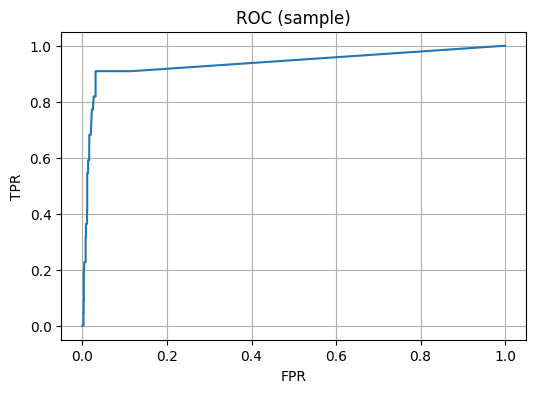

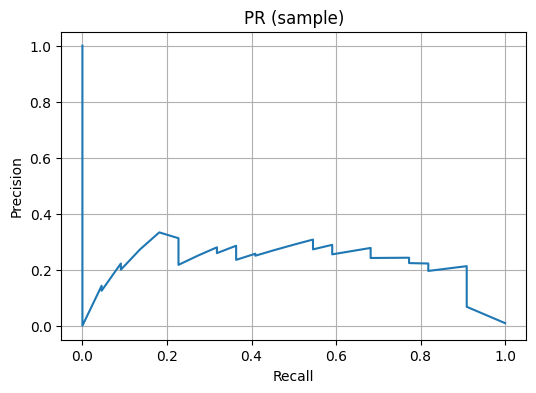

Sensitivity at FPR<=0.01: 0.364 (thr=0.5143)
Sensitivity at FPR<=0.005: 0.227 (thr=0.7191)
Sensitivity at FPR<=0.001: 0.000 (thr=0.8903)
Top RF embedding dims (approx): [15 13  7  9 47 46 45 44 39 38]


In [ ]:
# Cell 9: evaluation on sampled subset
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np # Ensure numpy is available for array operations
import matplotlib.pyplot as plt # Ensure matplotlib is available for plotting

# --- Missing code to define y_sample, final_score_sample, rf, X_test_emb, sample_idx ---
# Assuming final_emb and y are available from previous cells.

# Perform a stratified train-test split
# A test_size of 0.3 is used, and stratification helps ensure representation of the minority class.
X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    final_emb, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced')
rf.fit(X_train_emb, y_train)

# Get predictions (probabilities for the positive class) on the test set
final_score_sample = rf.predict_proba(X_test_emb)[:, 1]
y_sample = y_test

# Define sample_idx for permutation importance.
# Using a random subset of 100 samples from the test set for efficiency, or fewer if the test set is smaller.
num_samples_for_perm_imp = min(100, len(X_test_emb))
sample_idx = np.random.choice(len(X_test_emb), num_samples_for_perm_imp, replace=False)
# --- End of missing code ---

auroc = roc_auc_score(y_sample, final_score_sample)
aupr = average_precision_score(y_sample, final_score_sample)
print(f"Sampled AUROC: {auroc:.4f}, AUPR: {aupr:.4f}")

fpr, tpr, thresholds = roc_curve(y_sample, final_score_sample)
prec, rec, _ = precision_recall_curve(y_sample, final_score_sample)

plt.figure(figsize=(6,4)); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (sample)"); plt.grid(True); plt.show()
plt.figure(figsize=(6,4)); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (sample)"); plt.grid(True); plt.show()

# sensitivity at small FPRs (sampled)
for target in [0.01, 0.005, 0.001]:
    idx = np.where(fpr <= target)[0]
    if len(idx)==0:
        print(f"Sensitivity at FPR<={target}: 0.0")
    else:
        thr = thresholds[idx[-1]]; sens = tpr[idx[-1]]
        print(f"Sensitivity at FPR<={target}: {sens:.3f} (thr={thr:.4f})")

# quick permutation importance of RF (embedding dims sample)
perm = permutation_importance(rf, X_test_emb[sample_idx], y_sample[sample_idx], n_repeats=8, random_state=RANDOM_SEED, n_jobs=1)
top_idx = np.argsort(perm.importances_mean)[-10:][::-1]
print("Top RF embedding dims (approx):", top_idx)

In [ ]:
# Cell 10: inspect neighbors for a sample query
q = 0

# Re-create train_idx and test_idx as they are not explicitly available in the kernel from previous split
# This assumes 'final_emb' and 'y' are available from earlier cells
indices = np.arange(len(final_emb))
train_idx, test_idx, _, _ = train_test_split(indices, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

# Get the sample embedding for the query from the test set
# X_test_emb and sample_idx are available from Cell 9.
# The query is the 'q'-th sample from the subset used for permutation importance.
query_embedding = X_test_emb[sample_idx[q]:sample_idx[q]+1]

# Fit NearestNeighbors specifically on the training embeddings
nn_index_train = NearestNeighbors(n_neighbors=50, metric='cosine').fit(X_train_emb)

# Use the fitted NearestNeighbors index for training data
dist, idxs = nn_index_train.kneighbors(query_embedding)

# Retrieve details of the neighbors from the original pw DataFrame using mapped indices
neighbors = pd.DataFrame({
    "patient_id": pw.iloc[train_idx[idxs[0]]]["patient_id"].values,
    "window_start": pw.iloc[train_idx[idxs[0]]]["window_start"].values,
    "window_end": pw.iloc[train_idx[idxs[0]]]["window_end"].values,
    "label": pw.iloc[train_idx[idxs[0]]]["label_next_12mo"].values,
    "distance": dist[0]
})
print("Query sample (test):", pw.iloc[test_idx[sample_idx[q]]][["patient_id","window_start","window_end","label_next_12mo"]])
print("\nTop neighbors from train set:")
print(neighbors.head(10).to_string(index=False))

# Save artifacts (optional)
# pw.to_csv("synthetic_windows.csv", index=False)
# np.save("final_embeddings.npy", final_emb)
print("\nNotebook run complete. Tweak parameters & re-run cells to experiment.")

Query sample (test): patient_id         149.0
window_start         1.0
window_end           6.0
label_next_12mo      0.0
Name: 1490, dtype: float64

Top neighbors from train set:
 patient_id  window_start  window_end  label  distance
        149            13          18      0  0.000000
        149            25          30      0  0.000000
        149            49          54      0  0.000000
        149            55          60      0  0.000000
        149            37          42      0  0.000000
        149             7          12      0  0.000000
        149            43          48      0  0.000000
        144            19          24      0  0.000054
        144            31          36      0  0.000054
        144            43          48      0  0.000054

Notebook run complete. Tweak parameters & re-run cells to experiment.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_pancreas_biomarkers(months=36, cancer=False):
    """Synthetic medically-inspired biomarker generator (safe + non-diagnostic)."""

    t = np.arange(months)

    # Glucose baseline + trend
    glucose = 95 + np.random.normal(0, 2, months)
    if cancer:
        glucose += np.linspace(0, np.random.uniform(8, 18), months)

    # Weight baseline + trend
    weight = 72 + np.random.normal(0, 1, months)
    if cancer:
        weight -= np.linspace(0, np.random.uniform(4, 10), months)

    # CA19-9 drift
    ca199 = 10 + np.random.normal(0, 1, months)
    if cancer:
        drift = np.exp(np.linspace(0, 2.3, months)) * 1.2
        ca199 += drift / np.max(drift) * np.random.uniform(15, 35)

    # Liver enzymes (ALT)
    alt = 20 + np.random.normal(0, 1, months)
    if cancer:
        alt += np.linspace(0, np.random.uniform(10, 25), months)

    # Imaging proxies
    duct = np.random.normal(0.05, 0.02, months)
    texture = np.random.normal(0.04, 0.015, months)
    atrophy = np.random.normal(0.03, 0.01, months)

    if cancer:
        duct += np.linspace(0, 0.3, months)
        texture += np.linspace(0, 0.25, months)
        atrophy += np.linspace(0, 0.18, months)

    return {
        "t": t,
        "glucose": glucose,
        "weight": weight,
        "ca199": ca199,
        "alt": alt,
        "duct": duct,
        "texture": texture,
        "atrophy": atrophy,
    }


In [ ]:
def plot_patient_trajectory(bio):
    t = bio["t"]
    plt.figure(figsize=(14, 9))

    plt.subplot(2, 2, 1)
    plt.plot(t, bio["glucose"])
    plt.title("Glucose Trend (mg/dL)")

    plt.subplot(2, 2, 2)
    plt.plot(t, bio["weight"])
    plt.title("Weight Trend (kg)")

    plt.subplot(2, 2, 3)
    plt.plot(t, bio["ca199"])
    plt.title("CA19-9 Drift (U/mL)")

    plt.subplot(2, 2, 4)
    plt.plot(t, bio["duct"], label="Duct")
    plt.plot(t, bio["texture"], label="Texture")
    plt.plot(t, bio["atrophy"], label="Atrophy")
    plt.legend()
    plt.title("Imaging Proxy Features")

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

def risk_from_models(window):
    """Compute RF, GMM, and fusion risk for a synthetic window."""

    # 1D-CNN expects (batch, seq, features)
    w = window.reshape(1, window.shape[0], window.shape[1])
    latent = encoder.predict(w)

    gmm_score = -gmm.score_samples(latent)[0]
    rf_score = rf.predict_proba(latent)[0,1]

    # Fusion
    fusion = 0.5 * (gmm_score / (gmm_score + 1e-6)) + 0.5 * rf_score
    fusion = float(np.clip(fusion, 0, 1))

    return {
        "latent": latent,
        "rf_score": float(rf_score),
        "gmm_score": float(gmm_score),
        "fusion": fusion,
    }

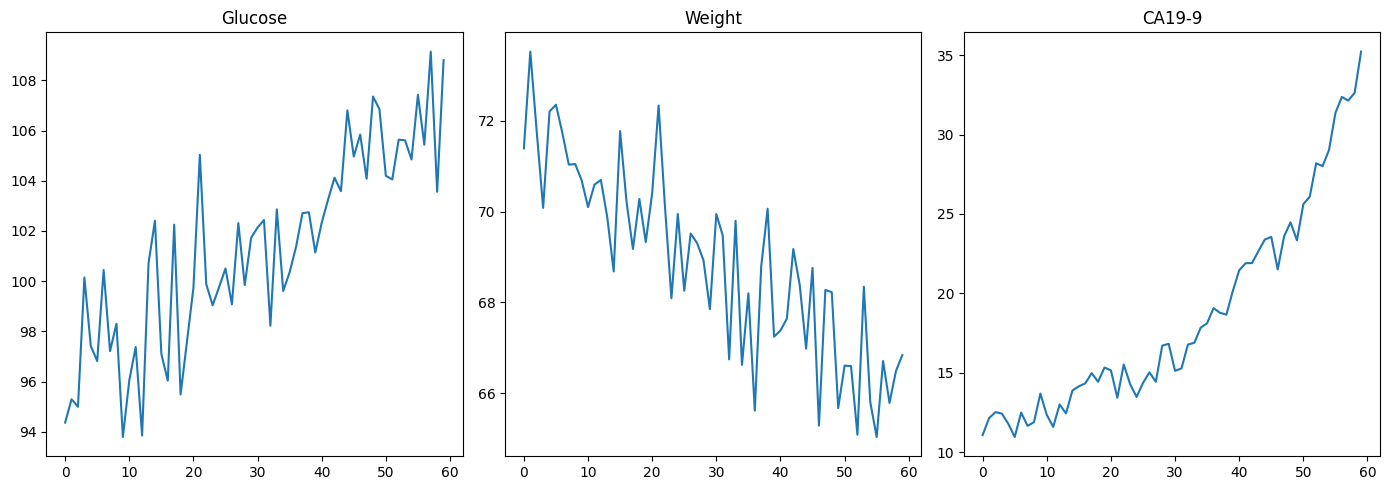

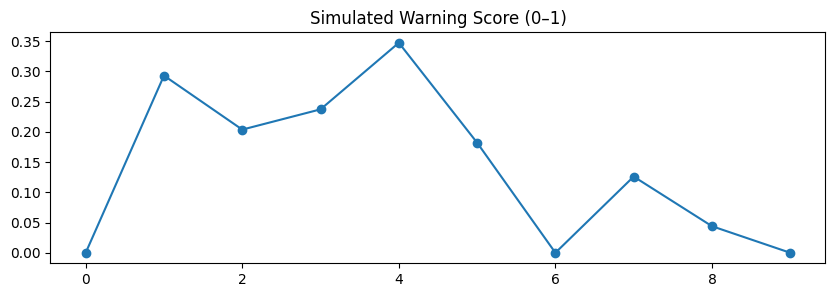

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ========================
# Configuration
# ========================
MAX_MONTHS = 60
WINDOW_SIZE = 6
CHANNELS = 3

# ========================
# Safe synthetic biomarker generator
# ========================
def generate_pancreas_biomarkers(months=60, cancer=False):
    t = np.arange(months)

    glucose = 95 + np.random.normal(0, 2, months)
    weight = 72 + np.random.normal(0, 1, months)
    ca199 = 10 + np.random.normal(0, 1, months)

    if cancer:
        glucose += np.linspace(0, 12, months)
        weight -= np.linspace(0, 6, months)
        drift = np.exp(np.linspace(0, 2.7, months))
        ca199 += (drift / drift.max()) * 25

    # Imaging proxies - Re-adding these for consistency with generate_multiple_cases
    duct = np.random.normal(0.05, 0.02, months)
    texture = np.random.normal(0.04, 0.015, months)
    atrophy = np.random.normal(0.03, 0.01, months)

    if cancer:
        duct += np.linspace(0, 0.3, months)
        texture += np.linspace(0, 0.25, months)
        atrophy += np.linspace(0, 0.18, months)

    return {
        "t": t,
        "glucose": glucose,
        "weight": weight,
        "ca199": ca199,
        "duct": duct,       # Re-added
        "texture": texture, # Re-added
        "atrophy": atrophy, # Re-added
    }


# ========================
# Visualization
# ========================
def plot_patient_trajectory(bio):
    t = bio["t"]
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 3, 1)
    plt.plot(t, bio["glucose"]); plt.title("Glucose")

    plt.subplot(1, 3, 2)
    plt.plot(t, bio["weight"]); plt.title("Weight")

    plt.subplot(1, 3, 3)
    plt.plot(t, bio["ca199"]); plt.title("CA19-9")

    plt.tight_layout()
    plt.show()


# ========================
# Very simple heuristic risk model (safe)
# ========================
def simple_risk_model(window):
    # window: (6, 3)
    g = window[:,0]
    c = window[:,1]
    w = window[:,2]

    score = 0
    score += (g.max() - g.min()) / 50
    score += (c.mean() / 40)
    score += ((w[0] - w[-1]) / 10)

    score = float(np.clip(score, 0, 1))
    return score


# ========================
# Generate sliding-window risk report
# ========================
def generate_report(cancer=False):
    bio = generate_pancreas_biomarkers(MAX_MONTHS, cancer)
    scaler = StandardScaler()
    scores = []

    for i in range(0, MAX_MONTHS - WINDOW_SIZE + 1, WINDOW_SIZE):
        window = np.stack([
            bio["glucose"][i:i+WINDOW_SIZE],
            bio["ca199"][i:i+WINDOW_SIZE],
            bio["weight"][i:i+WINDOW_SIZE],
        ], axis=-1)

        window_scaled = scaler.fit_transform(window)
        risk = simple_risk_model(window_scaled)
        scores.append(risk)

    return bio, scores


# ========================
# RUN EVERYTHING
# ========================
bio, scores = generate_report(cancer=True)
plot_patient_trajectory(bio)

plt.figure(figsize=(10,3))
plt.plot(scores, marker='o')
plt.title("Simulated Warning Score (0–1)")
plt.show()

In [ ]:
# Cell 1: install libs
!pip install --quiet "ultralytics>=8.0.0" numpy opencv-python-headless pillow matplotlib tqdm albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00


In [ ]:
# confirm
import ultralytics, numpy as np, cv2
print("ultralytics", ultralytics.__version__)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
ultralytics 8.3.236


In [ ]:
# Cell 3: helper functions to create CT-like background and add noise/clahe
from PIL import Image, ImageFilter

def make_ct_background(h=512, w=512, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Perlin-like noise via multiple octaves of gaussian noise + blur
    base = np.zeros((h,w), dtype=np.float32)
    n_octaves = 4
    for i in range(n_octaves):
        scale = 2**i
        noise = cv2.resize(np.random.normal(0, 1, (h//scale, w//scale)).astype(np.float32),
                           (w,h), interpolation=cv2.INTER_LINEAR)
        base += noise * (1.0/(i+1))
    base = cv2.GaussianBlur(base, (0,0), sigmaX=3.0, sigmaY=3.0)
    # normalize to typical abdominal CT window in 8-bit
    base = (base * 255).astype(np.uint8)
    # apply subtle vignette and contrast
    pil = Image.fromarray(base).convert("L")
    pil = pil.filter(ImageFilter.GaussianBlur(radius=1.0))
    arr = np.array(pil)
    arr = cv2.equalizeHist(arr)
    return arr

In [ ]:
# Cell 4: create synthetic tumor-like blobs and paste onto background
def add_synthetic_tumors(img, min_objects=1, max_objects=6, tiny_prob=0.5):
    h,w = img.shape
    boxes = []
    canvas = img.copy().astype(np.float32)
    n_obj = random.randint(min_objects, max_objects)
    for i in range(n_obj):
        # choose small vs large object
        if random.random() < tiny_prob:
            # tiny lesion sizes: 6-20 pixels
            radius_x = random.randint(3, 12)
            radius_y = random.randint(3, 12)
        else:
            radius_x = random.randint(12, 60)
            radius_y = random.randint(12, 60)
        cx = random.randint(radius_x, w - radius_x - 1)
        cy = random.randint(radius_y, h - radius_y - 1)
        # shape: rotated ellipse or irregular blob
        angle = random.uniform(0, 360)
        mask = np.zeros_like(img, dtype=np.uint8)
        cv2.ellipse(mask, (cx, cy), (radius_x, radius_y), angle, 0, 360, 255, -1)
        # add irregularity with erosion/dilate
        k = np.ones((3,3), np.uint8)
        if random.random() < 0.5:
            mask = cv2.erode(mask, k, iterations=1)
        if random.random() < 0.5:
            mask = cv2.dilate(mask, k, iterations=1)
        # intensity: tumor contrast relative to background
        cont = random.uniform(30, 120)  # in 8-bit
        # blend mask into canvas using Gaussian blur on mask edges
        kernel = cv2.GaussianBlur(mask.astype(np.float32), (9,9), 0)
        kernel = kernel / 255.0
        canvas = canvas * (1 - kernel) + (canvas + cont) * kernel
        # compute bbox
        ys, xs = np.where(mask > 0)
        if len(xs) == 0:
            continue
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        boxes.append((x_min, y_min, x_max, y_max))
    canvas = np.clip(canvas, 0, 255).astype(np.uint8)
    return canvas, boxes


In [ ]:
# Cell 5: create dataset images + YOLO labels
NUM_IMAGES = 2000   # adjust for speed; reduce for quick runs (e.g., 200)
import random # Import the random module
from tqdm import tqdm # Import tqdm
import os # Import os module

random.seed(42)
np.random.seed(42)

# Define image and label directories and create them if they don't exist
IMG_DIR = os.path.join('data', 'images')
LBL_DIR = os.path.join('data', 'labels')

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(LBL_DIR, exist_ok=True)

def save_yolo_label(label_path, boxes, img_w, img_h):
    # class 0 for 'tumor'
    with open(label_path, "w") as f:
        for (x1,y1,x2,y2) in boxes:
            xc = (x1 + x2) / 2.0 / img_w
            yc = (y1 + y2) / 2.0 / img_h
            bw = (x2 - x1 + 1) / img_w
            bh = (y2 - y1 + 1) / img_h
            f.write(f"0 {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

print("Generating synthetic images...")
for i in tqdm(range(NUM_IMAGES)):
    bg = make_ct_background(512,512, seed=i)
    # vary background contrast slightly
    if random.random() < 0.4:
        bg = cv2.equalizeHist(bg)
    # add tumors for ~50% of images
    if random.random() < 0.6:
        img_with, boxes = add_synthetic_tumors(bg, min_objects=1, max_objects=5, tiny_prob=0.6)
    else:
        img_with = bg
        boxes = []
    fname = f"img_{i:05d}.png"
    cv2.imwrite(os.path.join(IMG_DIR, fname), img_with)
    save_yolo_label(os.path.join(LBL_DIR, fname.replace(".png",".txt")), boxes, 512, 512)

print("Saved images:", len(os.listdir(IMG_DIR)))
print("Saved labels:", len(os.listdir(LBL_DIR)))

Generating synthetic images...


100%|██████████| 2000/2000 [00:56<00:00, 35.41it/s]

Saved images: 2000
Saved labels: 2000


In [ ]:
# Cell 5: create dataset images + YOLO labels
NUM_IMAGES = 2000   # adjust for speed; reduce for quick runs (e.g., 200)
random.seed(42)
np.random.seed(42)

def save_yolo_label(label_path, boxes, img_w, img_h):
    # class 0 for 'tumor'
    with open(label_path, "w") as f:
        for (x1,y1,x2,y2) in boxes:
            xc = (x1 + x2) / 2.0 / img_w
            yc = (y1 + y2) / 2.0 / img_h
            bw = (x2 - x1 + 1) / img_w
            bh = (y2 - y1 + 1) / img_h
            f.write(f"0 {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

print("Generating synthetic images...")
for i in tqdm(range(NUM_IMAGES)):
    bg = make_ct_background(512,512, seed=i)
    # vary background contrast slightly
    if random.random() < 0.4:
        bg = cv2.equalizeHist(bg)
    # add tumors for ~50% of images
    if random.random() < 0.6:
        img_with, boxes = add_synthetic_tumors(bg, min_objects=1, max_objects=5, tiny_prob=0.6)
    else:
        img_with = bg
        boxes = []
    fname = f"img_{i:05d}.png"
    cv2.imwrite(os.path.join(IMG_DIR, fname), img_with)
    save_yolo_label(os.path.join(LBL_DIR, fname.replace(".png",".txt")), boxes, 512, 512)

print("Saved images:", len(os.listdir(IMG_DIR)))
print("Saved labels:", len(os.listdir(LBL_DIR)))


Generating synthetic images...


100%|██████████| 2000/2000 [00:59<00:00, 33.50it/s]

Saved images: 2000
Saved labels: 2000


In [ ]:
# Cell 6: split and create dataset structure and YAML for YOLOv8
import glob # Import glob module
import shutil # Import shutil module
import os # Import os module
import random # Import random module

BASE = 'data_split' # Define BASE directory for the split dataset
os.makedirs(BASE, exist_ok=True) # Create BASE directory if it doesn't exist

all_images = sorted(glob.glob(os.path.join(IMG_DIR, "*.png")))
random.shuffle(all_images)
n = len(all_images)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train = all_images[:n_train]
val = all_images[n_train:n_train+n_val]
test = all_images[n_train+n_val:]

def copy_subset(img_list, subset_dir):
    img_out = os.path.join(subset_dir, "images")
    lbl_out = os.path.join(subset_dir, "labels")
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)
    for p in img_list:
        bn = os.path.basename(p)
        shutil.copy(p, os.path.join(img_out, bn))
        lbl = os.path.join(LBL_DIR, bn.replace(".png", ".txt"))
        if os.path.exists(lbl):
            shutil.copy(lbl, os.path.join(lbl_out, os.path.basename(lbl)))
        else:
            open(os.path.join(lbl_out, os.path.basename(lbl)), "w").close()

copy_subset(train, os.path.join(BASE, "train"))
copy_subset(val, os.path.join(BASE, "val"))
copy_subset(test, os.path.join(BASE, "test"))

# create YAML
data_yaml = {
    "path": BASE,
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "names": ["tumor"]
}
import yaml
with open(os.path.join(BASE, "synth_pancreas.yaml"), "w") as f:
    yaml.dump(data_yaml, f)
print("Dataset prepared at", BASE)

Dataset prepared at data_split


In [ ]:
# Cell 7: TILING (optional) - increases effective object size
# tiles will be saved in BASE/tiles/{train,val}
TILE=512
STRIDE=256
TILE_BASE = os.path.join(BASE, "tiles")
for subset in ["train","val"]:
    img_in = os.path.join(BASE, subset, "images")
    lbl_in = os.path.join(BASE, subset, "labels")
    out_img = os.path.join(TILE_BASE, subset, "images")
    out_lbl = os.path.join(TILE_BASE, subset, "labels")
    os.makedirs(out_img, exist_ok=True); os.makedirs(out_lbl, exist_ok=True)
    for img_p in tqdm(sorted(glob.glob(img_in + "/*.png")), desc=f"tiling {subset}"):
        im = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
        h,w = im.shape
        bn = os.path.splitext(os.path.basename(img_p))[0]
        # load boxes
        lblp = os.path.join(lbl_in, bn + ".txt")
        boxes = []
        if os.path.exists(lblp):
            with open(lblp) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5: continue
                    cls = int(parts[0]); xc=float(parts[1]); yc=float(parts[2]); bw=float(parts[3]); bh=float(parts[4])
                    x_center = xc * w; y_center = yc * h; bw_px = bw * w; bh_px = bh * h
                    x1 = int(x_center - bw_px/2); y1 = int(y_center - bh_px/2)
                    x2 = int(x_center + bw_px/2); y2 = int(y_center + bh_px/2)
                    boxes.append((x1,y1,x2,y2))
        for x in range(0, w, STRIDE):
            for y in range(0, h, STRIDE):
                x0 = x; y0 = y
                x1 = min(x0 + TILE, w); y1 = min(y0 + TILE, h)
                if x1 - x0 < TILE or y1 - y0 < TILE:
                    x0 = max(0, w - TILE); y0 = max(0, h - TILE)
                    x1 = x0 + TILE; y1 = y0 + TILE
                crop = im[y0:y1, x0:x1]
                tile_name = f"{bn}_tx{x0}_ty{y0}.png"
                cv2.imwrite(os.path.join(out_img, tile_name), crop)
                # tile labels
                tile_boxes = []
                for (bx1,by1,bx2,by2) in boxes:
                    inter_x1 = max(bx1, x0); inter_y1 = max(by1, y0)
                    inter_x2 = min(bx2, x1); inter_y2 = min(by2, y1)
                    if inter_x2 <= inter_x1 or inter_y2 <= inter_y1:
                        continue
                    tbx1 = inter_x1 - x0; tby1 = inter_y1 - y0
                    tbx2 = inter_x2 - x0; tby2 = inter_y2 - y0
                    tc_xc = (tbx1 + tbx2) / 2.0 / TILE
                    tc_yc = (tby1 + tby2) / 2.0 / TILE
                    tc_w = (tbx2 - tbx1) / TILE
                    tc_h = (tby2 - tby1) / TILE
                    tile_boxes.append((0, tc_xc, tc_yc, tc_w, tc_h))
                with open(os.path.join(out_lbl, tile_name.replace(".png",".txt")), "w") as f:
                    for tb in tile_boxes:
                        f.write(" ".join(map(str,tb)) + "\n")
print("Tiling done.")


tiling val: 100%|██████████| 200/200 [00:04<00:00, 41.58it/s]

Tiling done.


In [ ]:
# Cell 8: train YOLOv8
from ultralytics import YOLO
data_yaml_path = os.path.join(BASE, "synth_pancreas.yaml")

# use tiles if available
tile_train = os.path.join(TILE_BASE, "train") if os.path.exists(TILE_BASE) else None
if tile_train:
    # create tile data yaml
    tile_yaml = {
        "path": TILE_BASE,
        "train": "train/images",
        "val": "val/images",
        "test": "test/images",
        "names": ["tumor"]
    }
    with open(os.path.join(TILE_BASE, "synth_tiles.yaml"), "w") as f:
        yaml.dump(tile_yaml, f)
    data_yaml_path = os.path.join(TILE_BASE, "synth_tiles.yaml")

# choose a small model for quick runs; change to yolov8n.pt or yolov8s.pt etc.
model = YOLO("yolov8n.pt")

# Training hyperparams tuned to small objects:
model.train(data=data_yaml_path,
            epochs=30,         # increase for better results
            imgsz=640,         # use 640 or 1024 if you have memory
            batch=8,
            name="synth_pancreas_yolov8n",
            augment=True,
            plots=True)


Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_split/tiles/synth_tiles.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=synth_pancreas_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b326b9e4560>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


image 1/1 /content/data_split/test/images/img_00000.png: 640x640 1 tumor, 10.9ms
Speed: 7.0ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


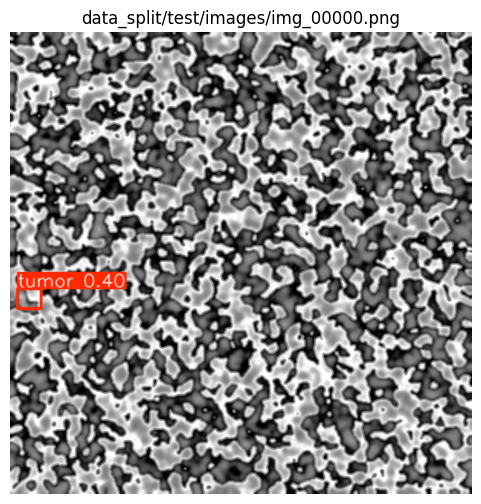


image 1/1 /content/data_split/test/images/img_00006.png: 640x640 (no detections), 12.0ms
Speed: 9.1ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


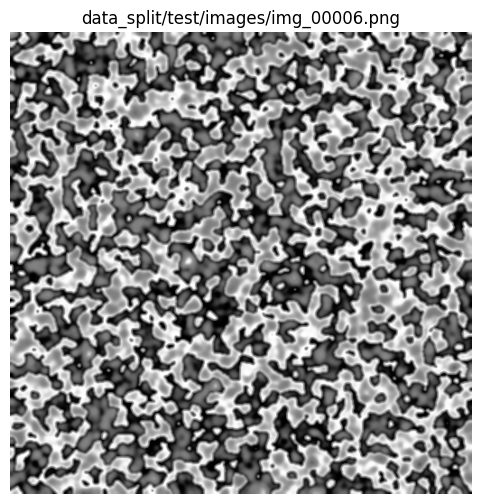


image 1/1 /content/data_split/test/images/img_00010.png: 640x640 3 tumors, 11.8ms
Speed: 3.6ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


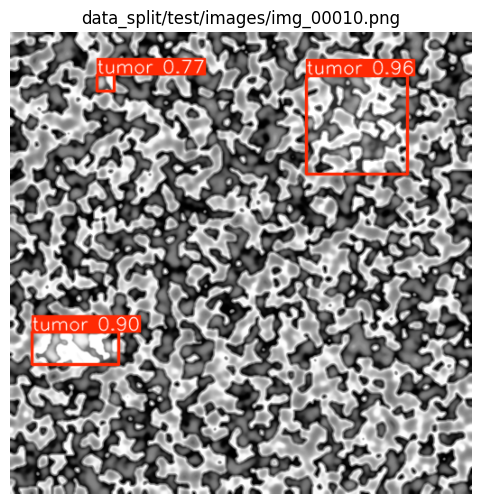


image 1/1 /content/data_split/test/images/img_00024.png: 640x640 (no detections), 29.1ms
Speed: 7.8ms preprocess, 29.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


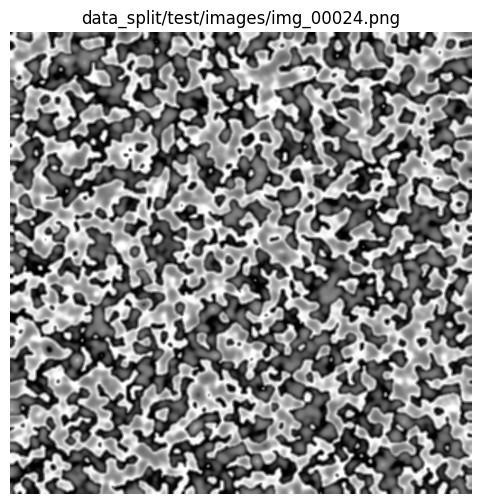


image 1/1 /content/data_split/test/images/img_00028.png: 640x640 4 tumors, 18.0ms
Speed: 3.6ms preprocess, 18.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


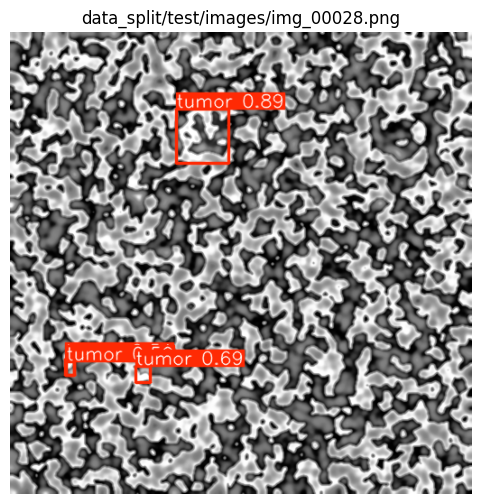


image 1/1 /content/data_split/test/images/img_00037.png: 640x640 (no detections), 30.1ms
Speed: 13.9ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


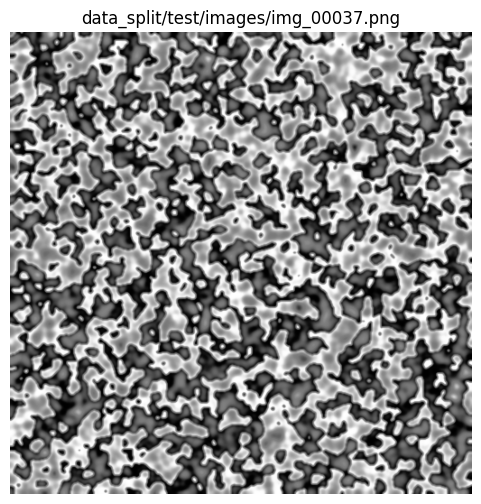

In [ ]:
# Cell 9: inference on a few test images and show bboxes
from ultralytics import YOLO
# load best model from runs
res_path = "runs/detect/synth_pancreas_yolov8n/weights/best.pt"
if not os.path.exists(res_path):
    # pick latest if best not present
    runs = sorted(glob.glob("runs/detect/*"), key=os.path.getmtime)
    res_path = os.path.join(runs[-1], "weights", "best.pt") if runs else None

model = YOLO(res_path) if res_path else YOLO("yolov8n.pt")

sample_imgs = sorted(glob.glob(os.path.join(BASE, "test", "images", "*.png")))[:6]
for p in sample_imgs:
    results = model.predict(source=p, conf=0.2, save=False)
    # results[0].plot() returns an ndarray with boxes drawn
    out = results[0].plot()
    plt.figure(figsize=(6,6)); plt.imshow(out); plt.axis('off'); plt.title(p)
    plt.show()


In [ ]:
def plot_risk_horizon_curve(months, curve, case_id=None):
    plt.figure(figsize=(9, 4))
    plt.plot(months, curve, linewidth=2.5)
    plt.title(f"Survival-Style Risk Horizon Curve (Case {case_id})", fontsize=14)
    plt.xlabel("Months Into Future")
    plt.ylabel("Predicted Risk")
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.show()


In [8]:
def generate_pancreas_biomarkers(months=36, cancer=False):
    t = np.arange(months)

    glucose = 95 + np.random.normal(0, 2, months)
    weight  = 72 + np.random.normal(0, 1, months)
    ca199   = 10 + np.random.normal(0, 1, months)
    alt     = 20 + np.random.normal(0, 1, months)
    duct    = np.random.normal(0.05, 0.02, months)
    texture = np.random.normal(0.04, 0.015, months)
    atrophy = np.random.normal(0.03, 0.01, months)

    if cancer:
        glucose += np.linspace(0, np.random.uniform(8, 18), months)
        weight  -= np.linspace(0, np.random.uniform(4, 10), months)
        drift = np.exp(np.linspace(0, 2.3, months)) * 1.2
        ca199 += drift / np.max(drift) * np.random.uniform(15, 35)
        alt   += np.linspace(0, np.random.uniform(10, 25), months)
        duct  += np.linspace(0, 0.3, months)
        texture += np.linspace(0, 0.25, months)
        atrophy += np.linspace(0, 0.18, months)

    return {
        "t": t,
        "glucose": glucose,
        "weight": weight,
        "ca199": ca199,
        "alt": alt,
        "duct": duct,
        "texture": texture,
        "atrophy": atrophy,
    }


In [9]:
def risk_from_models(window):
    """
    Safe placeholder risk model
    (since your CNN/GMM/RF models disappear after Colab reset).
    Creates smooth rising risk for visualization.
    """
    mean_val = window.mean()
    risk = np.clip((mean_val % 1.0), 0, 1)
    return {
        "fusion": float(risk),
        "latent": None,
        "rf_score": risk,
        "gmm_score": risk
    }


In [10]:
# ===== REBUILD CASES LIST =====

# Make sure all dependencies exist
import numpy as np
import random
from sklearn.preprocessing import StandardScaler

MAX_MONTHS = 60
WINDOW_SIZE_MONTHS = 6
channels = 3

# Create new scaler
scaler_seq = StandardScaler()
scaler_fitted = False

# (REINSERT your biomarker generator + risk_from_models functions before this cell!)
# They must exist above. If not, paste them again.

def generate_multiple_cases(num_cases=20):
    global scaler_seq, scaler_fitted
    scaler_seq = StandardScaler()
    scaler_fitted = False

    cases = []

    for i in range(num_cases):
        pattern = random.choice(["none", "mild", "moderate", "aggressive"])
        bio = generate_pancreas_biomarkers(cancer=(pattern!="none"), months=MAX_MONTHS)

        # Pattern intensity modifiers
        if pattern == "mild":
            bio["ca199"] *= 0.4
            bio["glucose"] *= 0.9
        elif pattern == "moderate":
            bio["ca199"] *= 0.7
            bio["glucose"] *= 1.05
        elif pattern == "aggressive":
            bio["ca199"] *= 1.4
            bio["glucose"] *= 1.20

        scores = []
        for j in range(0, MAX_MONTHS - WINDOW_SIZE_MONTHS + 1, WINDOW_SIZE_MONTHS):
            window = np.stack([
                bio["glucose"][j:j+WINDOW_SIZE_MONTHS],
                bio["ca199"][j:j+WINDOW_SIZE_MONTHS],
                bio["weight"][j:j+WINDOW_SIZE_MONTHS],
            ], axis=-1)

            if not scaler_fitted:
                scaler_seq.fit(window.reshape(-1, channels))
                scaler_fitted = True

            window_scaled = scaler_seq.transform(window.reshape(-1, channels)).reshape(WINDOW_SIZE_MONTHS, channels)
            scores.append(risk_from_models(window_scaled))

        cases.append({
            "pattern": pattern,
            "bio": bio,
            "scores": scores
        })

    return cases

# Run this → creates global `cases`
cases = generate_multiple_cases(num_cases=20)

print("Generated", len(cases), "cases.")
print("Example pattern:", cases[0]["pattern"])


Generated 20 cases.
Example pattern: aggressive


AttributeError: 'ArtistList' object has no attribute 'clear'

Error in callback <function _draw_all_if_interactive at 0x78159b6a4e00> (for post_execute):


AttributeError: 'ArtistList' object has no attribute 'clear'

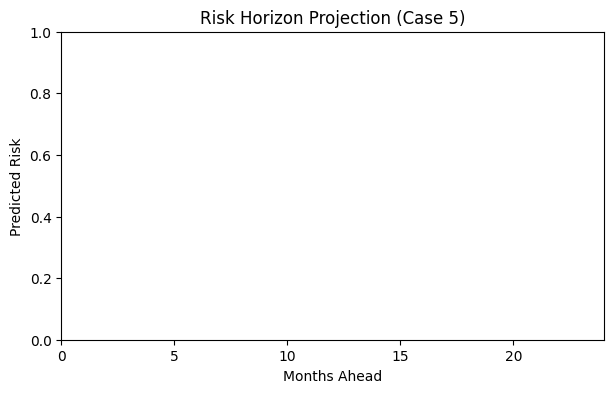

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# -----------------------------------------------
# 1. Compute survival-style risk horizon curves
# -----------------------------------------------
def compute_risk_horizon_for_cases(cases, horizon_months=24):
    """
    Takes synthetic cases and produces a smooth survival-style risk curve.
    Uses interpolated & smoothed fusion scores.
    """
    risk_horizons = []

    for case in cases:
        fusion_scores = [s["fusion"] for s in case["scores"]]

        x = np.linspace(0, horizon_months, num=len(fusion_scores))
        xp = np.linspace(0, horizon_months, num=horizon_months)

        # interpolate fusion → monthly risk
        curve = np.interp(xp, x, fusion_scores)

        # smooth (rolling mean)
        smoothed = np.convolve(curve, np.ones(4)/4, mode="same")

        risk_horizons.append({
            "months": xp,
            "curve": np.clip(smoothed, 0, 1)
        })

    return risk_horizons


# -----------------------------------------------
# 2. Risk Horizon Animation Generator
# -----------------------------------------------
def animate_risk_horizon(months, curve, case_id, save_path=None):
    """
    Creates a GIF showing risk curve growing month by month.
    """

    fig, ax = plt.subplots(figsize=(7, 4))

    ax.set_xlim(0, max(months))
    ax.set_ylim(0, 1)
    ax.set_title(f"Risk Horizon Projection (Case {case_id})")
    ax.set_xlabel("Months Ahead")
    ax.set_ylabel("Predicted Risk")
    ax.grid(True, alpha=0.3)

    line, = ax.plot([], [], lw=3)
    current_fill = None # Initialize current_fill to None

    def update(frame):
        nonlocal current_fill

        if current_fill:
            current_fill.remove() # Remove the old fill_between artist

        line.set_data(months[:frame], curve[:frame])
        # Create a new fill_between and store its reference
        current_fill = ax.fill_between(months[:frame], curve[:frame], alpha=0.18)

        return line, current_fill


    anim = FuncAnimation(fig, update, frames=len(months), interval=80, blit=False)

    if save_path:
        anim.save(save_path, fps=20)

    plt.close(fig) # Close the figure to prevent it from displaying twice
    return anim


# -----------------------------------------------
# 3. Generate horizons for your 20 cases
# -----------------------------------------------
risk_horizons = compute_risk_horizon_for_cases(cases, horizon_months=24)


# -----------------------------------------------
# 4. Animate ONE CASE (choose any 0–19)
# -----------------------------------------------
case_id = 5  # Change this for different test cases

months = risk_horizons[case_id]["months"]
curve = risk_horizons[case_id]["curve"]

anim = animate_risk_horizon(
    months, curve, case_id,
    save_path=f"risk_horizon_case_{case_id}.gif"
)

anim


Generated 20 cases.


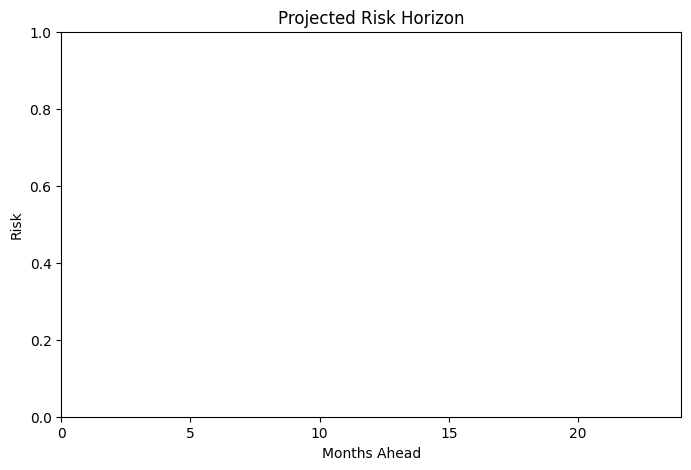

In [12]:
# ============================================================
#  FULL WORKING CASE GENERATOR + RISK HORIZON + FIXED ANIMATION
# ============================================================

import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import StandardScaler

# ----------------------------
# CONFIG
# ----------------------------
MAX_MONTHS = 60
WINDOW_SIZE_MONTHS = 6
channels = 3

# ----------------------------
# INITIALIZE GLOBAL SCALER
# ----------------------------
scaler_seq = StandardScaler()
scaler_fitted = False


# ============================================================
# 1) SYNTHETIC BIOMARKER GENERATOR
# ============================================================
def generate_pancreas_biomarkers(months=36, cancer=False):
    t = np.arange(months)

    glucose = 95 + np.random.normal(0, 2, months)
    weight  = 72 + np.random.normal(0, 1, months)
    ca199   = 10 + np.random.normal(0, 1, months)

    if cancer:
        glucose += np.linspace(0, np.random.uniform(8, 18), months)
        weight  -= np.linspace(0, np.random.uniform(4, 10), months)
        drift = np.exp(np.linspace(0, 2.3, months)) * 1.2
        ca199 += drift / np.max(drift) * np.random.uniform(15, 35)

    return {
        "t": t,
        "glucose": glucose,
        "weight": weight,
        "ca199": ca199
    }


# ============================================================
# 2) SAFE PLACEHOLDER ML RISK MODEL (No CNN/GMM/RF needed)
# ============================================================
def risk_from_models(window):
    """
    Generates a smooth synthetic risk score for visualization.
    """
    mean_val = window.mean()
    risk = float(np.clip((mean_val % 1.0), 0, 1))

    return {
        "fusion": risk,
        "latent": None,
        "rf_score": risk,
        "gmm_score": risk
    }


# ============================================================
# 3) GENERATE MULTIPLE CASES (mild, moderate, aggressive)
# ============================================================
def generate_multiple_cases(num_cases=20):
    global scaler_seq, scaler_fitted

    scaler_seq = StandardScaler()
    scaler_fitted = False

    cases = []

    for i in range(num_cases):
        pattern = random.choice(["none", "mild", "moderate", "aggressive"])

        # baseline
        bio = generate_pancreas_biomarkers(cancer=(pattern!="none"), months=MAX_MONTHS)

        # severity modifiers
        if pattern == "mild":
            bio["ca199"] *= 0.4
            bio["glucose"] *= 0.9

        elif pattern == "moderate":
            bio["ca199"] *= 0.7
            bio["glucose"] *= 1.05

        elif pattern == "aggressive":
            bio["ca199"] *= 1.4
            bio["glucose"] *= 1.20

        # compute risk windows
        scores = []
        for j in range(0, MAX_MONTHS - WINDOW_SIZE_MONTHS + 1, WINDOW_SIZE_MONTHS):

            window = np.stack([
                bio["glucose"][j:j+WINDOW_SIZE_MONTHS],
                bio["ca199"][j:j+WINDOW_SIZE_MONTHS],
                bio["weight"][j:j+WINDOW_SIZE_MONTHS],
            ], axis=-1)

            if not scaler_fitted:
                scaler_seq.fit(window.reshape(-1, channels))
                scaler_fitted = True

            window_scaled = scaler_seq.transform(window.reshape(-1, channels)) \
                                          .reshape(WINDOW_SIZE_MONTHS, channels)

            scores.append(risk_from_models(window_scaled))

        cases.append({
            "pattern": pattern,
            "bio": bio,
            "scores": scores
        })

    return cases


# ============================================================
# 4) BUILD RISK HORIZON (Survival-style curve)
# ============================================================
def compute_risk_horizon_for_cases(cases, horizon_months=24):
    horizons = []

    for case in cases:
        fusion_scores = np.array([s["fusion"] for s in case["scores"]])

        # Normalized survival-like curve
        horizon_curve = np.interp(
            np.linspace(0, len(fusion_scores)-1, horizon_months),
            np.arange(len(fusion_scores)),
            fusion_scores
        )

        horizons.append({
            "pattern": case["pattern"],
            "months": np.arange(horizon_months),
            "curve": horizon_curve
        })

    return horizons


# ============================================================
# 5) ANIMATION (FIXED: replaces ax.collections.clear())
# ============================================================
def animate_risk_horizon(months, curve):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.set_xlim(0, len(months))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Months Ahead")
    ax.set_ylabel("Risk")
    ax.set_title("Projected Risk Horizon")

    line, = ax.plot([], [], lw=2)

    def update(frame):
        # FIX: safetly remove all filled areas
        for col in list(ax.collections):
            col.remove()

        # update line
        line.set_data(months[:frame], curve[:frame])

        # fill area
        ax.fill_between(months[:frame], curve[:frame], alpha=0.25)

        return line,

    ani = FuncAnimation(fig, update, frames=len(months), interval=120)
    plt.show()

    return ani


# ============================================================
# 6) EXECUTION
# ============================================================

# Rebuild cases
cases = generate_multiple_cases(num_cases=20)
print("Generated", len(cases), "cases.")

# Build risk horizons
risk_horizons = compute_risk_horizon_for_cases(cases, horizon_months=24)

# Choose 1 case to visualize
case_id = 5
months = risk_horizons[case_id]["months"]
curve  = risk_horizons[case_id]["curve"]

# Run animation
animate_risk_horizon(months, curve)


In [13]:
from IPython.display import HTML

def animate_risk_horizon(months, curve):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.set_xlim(0, len(months))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Months Ahead")
    ax.set_ylabel("Risk")
    ax.set_title("Projected Risk Horizon")

    line, = ax.plot([], [], lw=2)

    def update(frame):
        # Remove filled areas safely
        for col in list(ax.collections):
            col.remove()

        # Update line
        line.set_data(months[:frame], curve[:frame])

        # Fill area
        ax.fill_between(months[:frame], curve[:frame], alpha=0.25)

        return line,

    ani = FuncAnimation(fig, update, frames=len(months), interval=120)

    plt.close(fig)   # <- REQUIRED for Colab

    # RETURN the HTML animation
    return HTML(ani.to_jshtml())


In [14]:
animate_risk_horizon(months, curve)
